### Imports

In [131]:
import numpy as np
import pandas as pd
from case_studies import *
import time
import matplotlib.pyplot as plt

In [132]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f4]
dfs = [df1, df4]
Hfs = [Hf1, Hf4]
fnames = ["f1", "f4"]

In [133]:
def backtracking_line_search(f, df, x, pk, alpha_init, c1, rho):
    
    alpha = alpha_init
    while f(x + alpha * pk) > f(x) + c1 * alpha * np.dot(df(x), pk):
        alpha *= rho
    return alpha

### Conjugate Gradients

In [134]:
#Max iter afhænger nok af newton som kalder CG, måske skal det hedde noget andet
def conjugate_gradients(Q, g, eps, max_iter=1000):
    x = 0
    grad = g
    p = -grad
    cg_xs = [x]
    for i in range(max_iter):
        alpha_k = -(np.dot(p, grad) / np.dot(p, np.dot(Q, p)))

        x = x + alpha_k * p
        
        grad = np.dot(Q, x) + g
        
        if np.linalg.norm(grad) < eps:
            break

        p = -grad + (np.dot(grad, np.dot(Q, p)) / np.dot(p, np.dot(Q, p))) * p
        
        cg_xs.append(x)
    return x, cg_xs

### Approximate Newton

In [135]:
def approximate_newton(x, f, df, hf, c1=1.0, rho=0.9, max_iter=1000, tol=1e-6):
    xs = [x]
    for i in range(max_iter):

        if np.linalg.norm(df(x)) < tol:
            break 
        
        n_k = 0.5 * min(0.5, np.sqrt(np.linalg.norm(df(x))))
        eps = n_k * np.linalg.norm(df(x))
        p, cg_xs = conjugate_gradients(hf(x), df(x), eps)
        alpha = backtracking_line_search(f, df, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)
    return x, xs, cg_xs

### Benchmarking

In [136]:
def benchmark(f, df, optimizer, x0, x_opt, Hf):
    start_time = time.time()

    x_final, xs, cg_xs = optimizer(x0, f, df, Hf)

    end_time = time.time()

    num_iterations = len(xs)
    final_solution_point = x_final
    dist_to_optimum = np.linalg.norm(x_final-x_opt)
    final_fun_value = f(xs[-1])
    duration = end_time-start_time
    
    grad_norms = [np.linalg.norm(df(x)) for x in xs]

    return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms)


In [137]:
x0 = np.random.randn(20)
# print(x0.shape)
benchmark_results = []

for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, 20)
    # print(x_optimal.shape)
    sd_result = benchmark(f, df, approximate_newton, x0, x_optimal, Hf)
    benchmark_results.append((fname, "Approximate newton") + sd_result)

# for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):    
    # x_optimal = x_opt(fname, len(x0))
    
    # nm_result = benchmark(f, df, conjugate_gradients, x0, x_optimal, Hf)
    # benchmark_results.append((fname, "Newton's Method") + nm_result)

# Convert to DataFrame
columns = ["Function", "Optimizer", "Iterations", "Time", "Final Function Value", "Final Solution Point", "Distance to Optimum", "Gradient Norms"]
df_results = pd.DataFrame(benchmark_results, columns=columns)

df_results

,Function,Optimizer,Iterations,Time,Final Function Value,Final Solution Point,Distance to Optimum,Gradient Norms
0,f1,Approximate newton,1001,4.931648,4129.756100,"[-0.18136022171702426, 0.5322382482786321, 0.4...",4.430990,"[3057.691657618703, 3057.691620520932, 3057.69..."
1,f4,Approximate newton,1001,17.935252,423.711643,"[-0.18136013237116672, 0.5322382578561575, 0.4...",4.431004,"[404.13630180910445, 404.1362973962002, 404.13..."


### Plotting

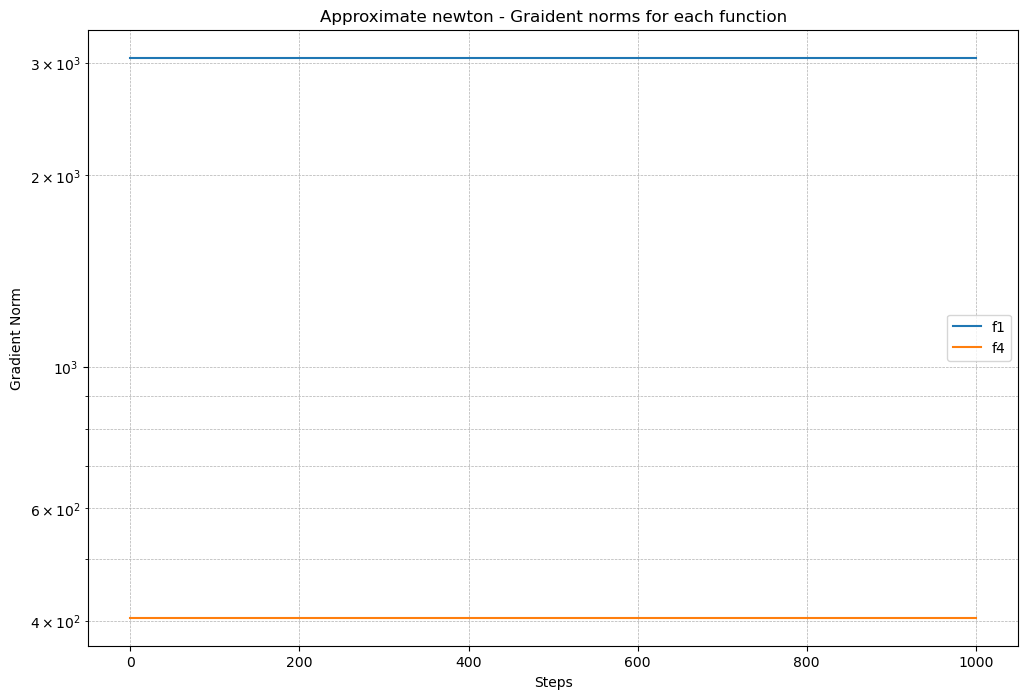

In [138]:
plt.figure(figsize=(12, 8))
for i in range(2):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Approximate newton - Graident norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()